In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import glob

In [5]:
root = Path(r"/nfs/nhome/live/jbhagat/ProjectAeon/aeon_analysis/aeon_analysis/presentations/upgrade/JonsData")
video_path = root / r"video_2019-12-13T09_07_18.avi"
video_metadata_path = root / "data" / "video-time_2019-12-13T09_07_16.csv"
quarterion_path = root / "data" / "processed" / "euler-corrected.raw"
skull_ori_path = root / "data" / "processed" / "euler-skull-frame.raw"
linear_acc_path  = root / "data" / "processed" / "linear-accel_2019-12-13T09_07_16.raw"
quarterion_metadata_path = root / "data" / "quaterion-time_2019-12-13T09_07_16.csv"

In [6]:
video = cv2.VideoCapture(str(video_path))
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

colnames=['Diff', 'Timestamp']

video_metadata = pd.read_csv(video_metadata_path, names=colnames, header=None, usecols=[9, 16])
video_metadata["Timestamp"] = pd.to_datetime(video_metadata["Timestamp"])
video_metadata.set_index("Timestamp", inplace=True)

print(f"Video length = {length}\nVideo Metadata length = {len(video_metadata)}" )

Video length = 0
Video Metadata length = 781558


In [ ]:
## Load Linear Acceleration Data
linear_acc = np.fromfile(linear_acc_path, dtype=np.dtype(np.float64))
linear_acc = np.reshape(linear_acc, (-1, 3))


Quart length = 1574757
Quart Metadata length = 1574757
Skull_orientation length = 1574757


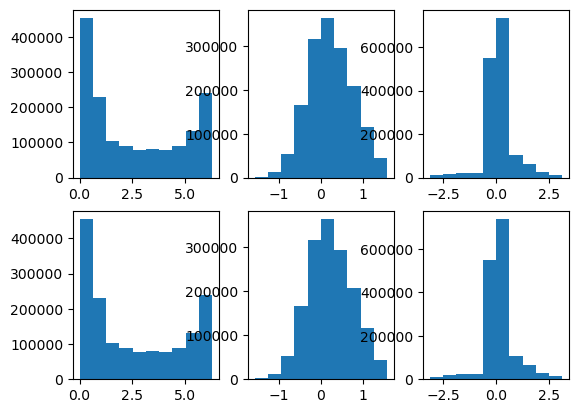

In [4]:
# Load x,y,z data
quart = np.fromfile(quarterion_path, dtype=np.dtype(np.float64))
quart = np.reshape(quart, (-1, 3))

colnames=['Timestamp', 'Counter']
quart_metadata = pd.read_csv(quarterion_metadata_path, names=colnames, header=None)
quart_metadata["Timestamp"] = pd.to_datetime(quart_metadata["Timestamp"])

skull_orientation = np.fromfile(skull_ori_path, dtype=np.dtype(np.float64))
skull_orientation = np.reshape(quart, (-1, 3))

print(f"Quart length = {quart.shape[0]}\nQuart Metadata length = {len(quart_metadata)}\nSkull_orientation length = {skull_orientation.shape[0]}" )

fig, axs = plt.subplots(2,3)
_ = [axs[0,i].hist(skull_orientation[:,i]) for i in range(3)]

_ = [axs[1,i].hist(quart[:,i]) for i in range(3)]


orientation = pd.concat([quart_metadata.reset_index(drop=True),
              pd.DataFrame(quart, columns = ['Quarterion_1','Quarterion_2','Quarterion_3']).reset_index(drop=True),
              pd.DataFrame(quart, columns = ['Skull_1','Skull_2','Skull_3']).reset_index(drop=True)],
              axis=1)
orientation.set_index("Timestamp", inplace=True)

orientation = orientation.reindex(video_metadata.index, method='nearest', tolerance='0.03s')


In [5]:
df_aligned = pd.concat([orientation.reset_index(drop=False),
              video_metadata.reset_index(drop=True)],
              axis=1)

len(df_aligned)

781558

In [6]:
## Load Bonsai.Sleap output

sleap_path = root / "sleap" / "data_alg"

sleap_files = glob.glob(str(sleap_path / "*.csv"))
sleap_files = [Path(f) for f in sleap_files if "alg_output.csv" not in f]

body_parts = {}
for file in sleap_files:
    bodyPart_name = file.name.split(".")[0]
    body_parts[bodyPart_name] = (pd.read_csv(file, header=None, skiprows=1,
                                  names=["x", "y", "p"]))



In [7]:
orientation_points = ["snout", "tailbase"]

orientation_vector = pd.DataFrame(
    {
    "x": body_parts[orientation_points[0]]["x"].values - body_parts[orientation_points[1]]["x"].values,
    "y": body_parts[orientation_points[0]]["y"].values - body_parts[orientation_points[1]]["y"].values
    })

orientation_vector["angle"] = np.arctan2(orientation_vector["y"], orientation_vector["x"])

In [8]:
## Load Kalman filtered output
FilteredOutput = []
for bodypart in orientation_points:
    bodypart_path = sleap_path / f"output_{bodypart}.pickle"
    FilteredOutput.append(np.load(bodypart_path, allow_pickle=True)["smooth_res"]["xnN"][(0,3),0,:])

FilteredOutput = FilteredOutput[0] - FilteredOutput[1]
orientation_vector["kalman_angle"] = np.arctan2(FilteredOutput[1,:], FilteredOutput[0,:])

In [9]:
def find_circular_abs(angle):
    test_arr = np.array([np.mod(angle, 2*np.pi), np.mod(angle, -2*np.pi)])
    return test_arr[np.argmin(np.abs(test_arr))]

prev = None
def unwrap_angle(angle, reset_on_nan=False, force_reset=False, drop_sample_threshold= np.pi*5):
    global prev
    if force_reset:
        prev = None
    curr = angle

    if (angle is None):
        if reset_on_nan:
            prev = angle # reset on NaN
            return None
        else: #if you don't want to reset just drop the value and return a diff of 0
            return 0

    if (prev is None): #Reset state
        prev = angle
        return None

    pos = np.array([curr, curr + 2 * np.pi, curr - 2 * np.pi])
    delta = pos - prev
    arg_min_delta = np.argmin(np.abs(delta))
    p = delta[arg_min_delta]
    if np.abs(p) > drop_sample_threshold:
        return 0
    else:
        prev = angle
    return -p

In [10]:
df_sub_aligned = pd.concat([orientation_vector, df_aligned], axis=1)
baseline_len = 100
downsample_factor = 1
calibration_factor = df_sub_aligned["Quarterion_1"].iloc[:baseline_len].median() - df_sub_aligned["angle"].iloc[:baseline_len].median()

df_sub_aligned["delta"] = df_sub_aligned["angle"] + calibration_factor - df_sub_aligned[f"Quarterion_1"]
df_sub_aligned["circ_delta"] = df_sub_aligned["delta"].apply(find_circular_abs)
df_sub_aligned["cumsum_circ_delta"] = np.cumsum(df_sub_aligned["circ_delta"])

df_sub_aligned["kalman_delta"] = df_sub_aligned["kalman_angle"] + calibration_factor - df_sub_aligned[f"Quarterion_1"]
df_sub_aligned["kalman_circ_delta"] = df_sub_aligned["kalman_delta"].apply(find_circular_abs)
df_sub_aligned["kalman_cumsum_circ_delta"] = np.cumsum(df_sub_aligned["kalman_circ_delta"])


df_sub_aligned["Commutator_quart"] = np.nan
df_sub_aligned["Commutator_angle"] = np.nan
df_sub_aligned["kalman_Commutator_angle"] = np.nan

df_sub_aligned = df_sub_aligned.loc[::downsample_factor,:]
df_sub_aligned.reset_index(drop=True, inplace=True)

unwrap_angle(None, force_reset=True)
for i in range(1,len(df_sub_aligned)):
    df_sub_aligned.at[i, "Commutator_quart"] = unwrap_angle(df_sub_aligned["Quarterion_1"].iloc[i])
unwrap_angle(None, force_reset=True)
for i in range(1,len(df_sub_aligned)):
    df_sub_aligned.at[i, "Commutator_angle"] = unwrap_angle(df_sub_aligned["angle"].iloc[i])
unwrap_angle(None, force_reset=True)
for i in range(1,len(df_sub_aligned)):
    df_sub_aligned.at[i, "kalman_Commutator_angle"] = unwrap_angle(df_sub_aligned["kalman_angle"].iloc[i])


df_sub_aligned["cumsum_Commutator_quart"] = np.cumsum(df_sub_aligned["Commutator_quart"])
df_sub_aligned["cumsum_Commutator_angle"] = np.cumsum(df_sub_aligned["Commutator_angle"])
df_sub_aligned["kalman_cumsum_Commutator_angle"] = np.cumsum(df_sub_aligned["kalman_Commutator_angle"])



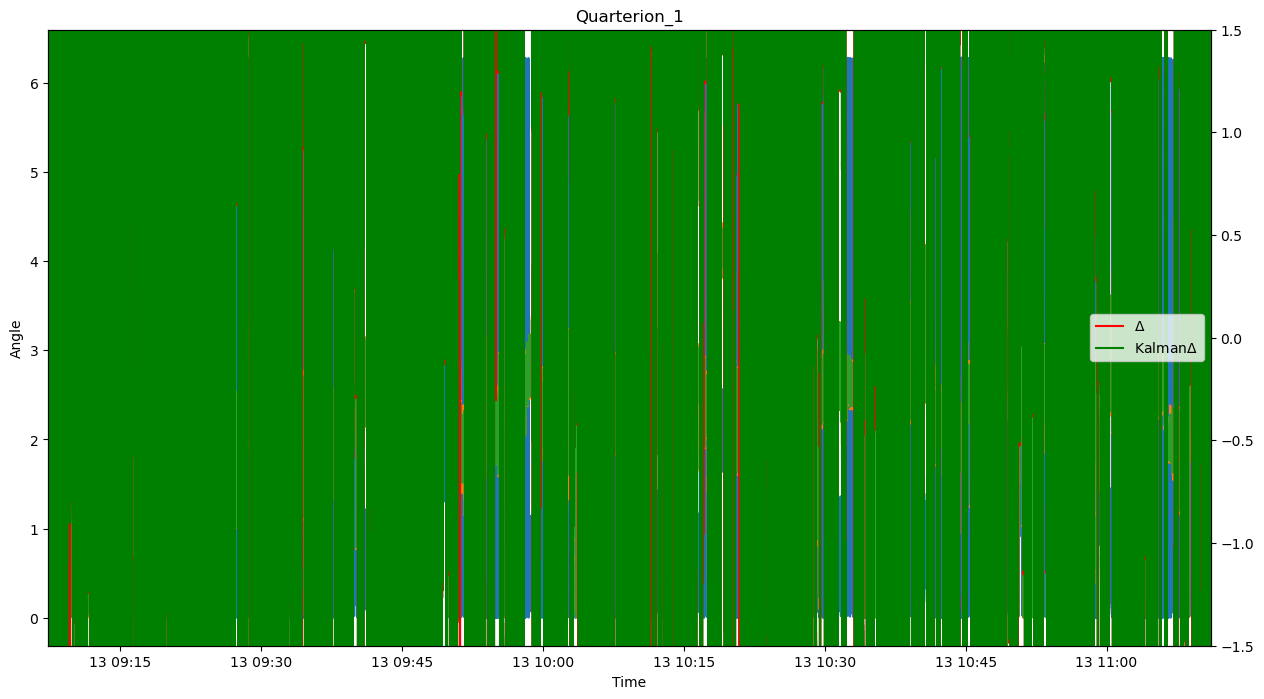

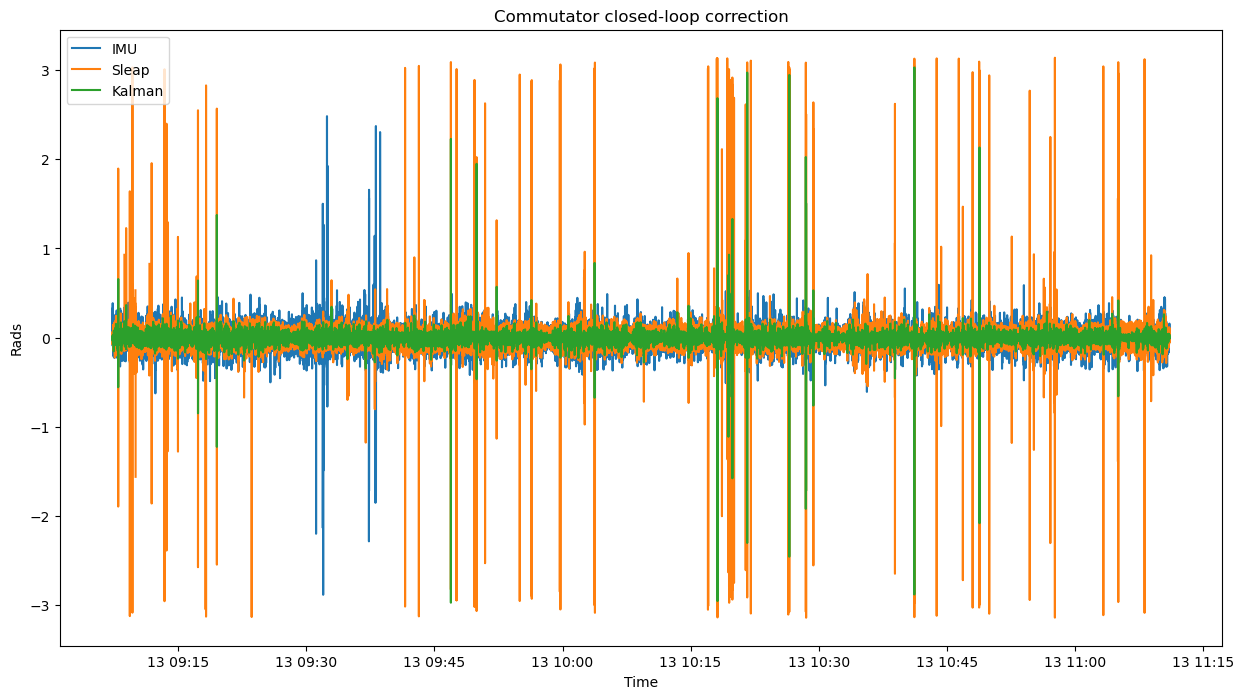

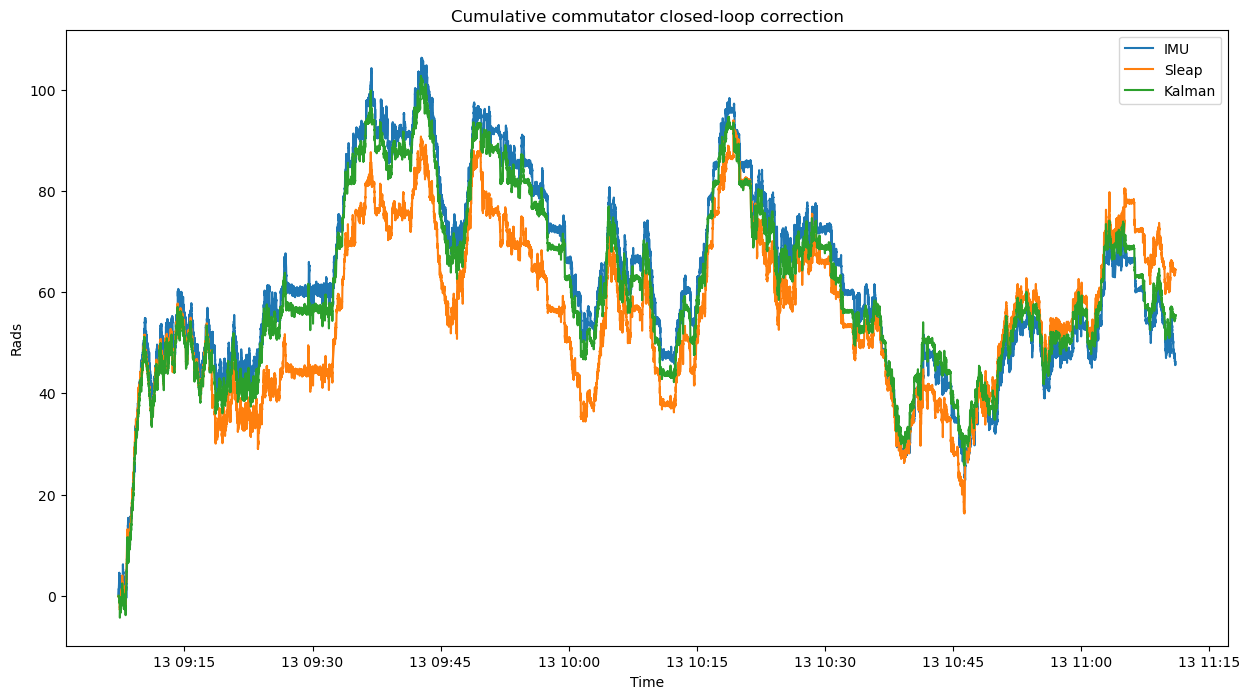

0 days 02:03:47.041331200
46.16783009489206
64.39604165638147
55.36177158080504


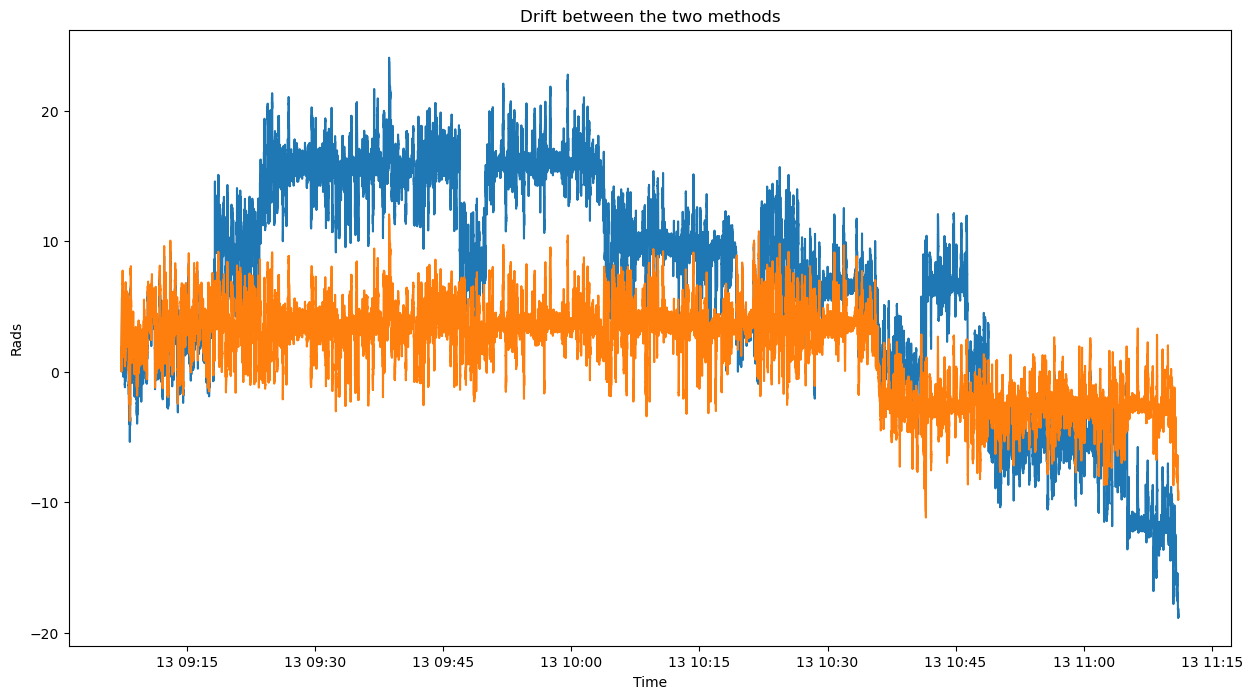

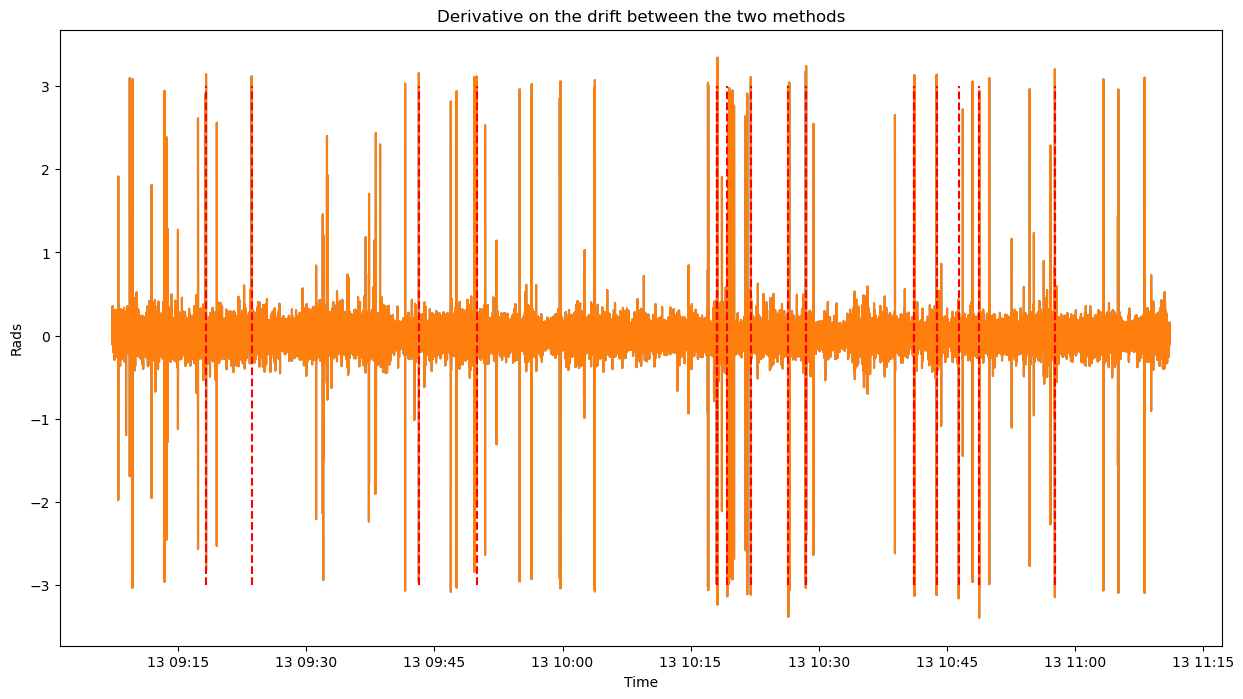

In [11]:
## Plot the outcome of the unwarping algorithm and the cummulative drift over time

samples2plot = range(0, np.argmax(np.cumsum(~np.isnan(df_sub_aligned["cumsum_Commutator_angle"].values)), ) - 1)
#samples2plot = range(int(32630/downsample_factor), int(32700/downsample_factor))
#samples2plot = range(0, 1000)

figsize = (15,8)


fig, ax = plt.subplots(1,1)
fig.set_size_inches(figsize)
ax.set_xlabel("Time")
ax.set_ylabel("Angle")
ax.plot(df_sub_aligned["Timestamp"].iloc[samples2plot], df_sub_aligned[f"Quarterion_1"].iloc[samples2plot], label="IMU")
ax.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        np.mod(df_sub_aligned["angle"] + calibration_factor, 2*np.pi)[samples2plot], label="Sleap")
ax.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        np.mod(df_sub_aligned["kalman_angle"] + calibration_factor, 2*np.pi)[samples2plot], label="kalman")
ax.set_title(f"Quarterion_1")
ax.set_xlim((df_sub_aligned["Timestamp"].iloc[samples2plot[0]], df_sub_aligned["Timestamp"].iloc[samples2plot[-1]]))

ax2 = ax.twinx()
ax2.yaxis.tick_right()
ax2.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["circ_delta"].iloc[samples2plot], color="red", label="$\Delta$")
ax2.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["kalman_circ_delta"].iloc[samples2plot], color="green", label="Kalman$\Delta$")
ax2.set_ylim((-1.5, 1.5))
plt.legend()
plt.show()


plt.figure(figsize=figsize)
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["Commutator_quart"].iloc[samples2plot], label="IMU")
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["Commutator_angle"].iloc[samples2plot], label="Sleap")
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["kalman_Commutator_angle"].iloc[samples2plot], label="Kalman")
plt.xlabel("Time")
plt.ylabel("Rads")
plt.title("Commutator closed-loop correction")
plt.legend()
plt.show()

plt.figure(figsize=figsize)
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        (df_sub_aligned["cumsum_Commutator_quart"].iloc[samples2plot]), label="IMU")
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        (df_sub_aligned["cumsum_Commutator_angle"].iloc[samples2plot]), label="Sleap")
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        (df_sub_aligned["kalman_cumsum_Commutator_angle"].iloc[samples2plot]), label="Kalman")
plt.xlabel("Time")
plt.ylabel("Rads")
plt.title("Cumulative commutator closed-loop correction")
plt.legend()
plt.show()

end = np.argmax(np.cumsum(~np.isnan(df_sub_aligned["cumsum_Commutator_angle"].iloc[samples2plot].values)), ) - 2
print(df_sub_aligned["Timestamp"].iloc[end] - df_sub_aligned["Timestamp"].iloc[0])
print(df_sub_aligned["cumsum_Commutator_quart"].iloc[samples2plot].values[end])
print(df_sub_aligned["cumsum_Commutator_angle"].iloc[samples2plot].values[end])
print(df_sub_aligned["kalman_cumsum_Commutator_angle"].iloc[samples2plot].values[end])


## Compare drift between methods
plt.figure(figsize=figsize)
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["cumsum_Commutator_quart"].iloc[samples2plot] -
        df_sub_aligned["cumsum_Commutator_angle"].iloc[samples2plot])
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot],
        df_sub_aligned["cumsum_Commutator_quart"].iloc[samples2plot] -
        df_sub_aligned["kalman_cumsum_Commutator_angle"].iloc[samples2plot])
plt.xlabel("Time")
plt.ylabel("Rads")
plt.title("Drift between the two methods")
plt.show()

## Detect skips
plt.figure(figsize=figsize)

derivative = np.diff(
            df_sub_aligned["cumsum_Commutator_quart"].iloc[samples2plot] -
            df_sub_aligned["cumsum_Commutator_angle"].iloc[samples2plot], prepend=np.NaN)

kalman_derivative = np.diff(
            df_sub_aligned["cumsum_Commutator_quart"].iloc[samples2plot] -
            df_sub_aligned["cumsum_Commutator_angle"].iloc[samples2plot], prepend=np.NaN)

threshold = np.pi * 0.99
hits = np.where(np.abs(derivative) >= threshold)[0]

plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot], derivative, label = "Derivative")
plt.plot(df_sub_aligned["Timestamp"].iloc[samples2plot], kalman_derivative, label = "kalman_Derivative")

plt.vlines(df_sub_aligned["Timestamp"].iloc[hits], ymin=-3, ymax=3, colors="red", linestyles="dashed", label=f"Hits > {threshold}")

plt.xlabel("Time")
plt.ylabel("Rads")
plt.title("Derivative on the drift between the two methods")
plt.show()